In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt

import seaborn as sns
sns.set(style="darkgrid")

In [ ]:
pwd

In [18]:
namepart = "results_0.16_100_12345"
results_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/" + namepart + ".txt"
#infections_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/results_-1286929029.txt"

In [26]:
r_data = pd.read_csv(results_filename, sep='\t')
#i_data = pd.read_csv(infections_filename, sep='\t')

In [ ]:
r_agg = r_data.groupby('myId').agg({'metric_died_count': 'sum'})
#r_agg = r_agg[r_agg['metric_new_cases_sympt'] > 5].sort_values(by='metric_new_cases_sympt', ascending=False)
#dist_name = r_agg['myId']
#r_agg['district_id'] = r_agg['myId']
r_agg['districtId'] = [int(str(x).split('_')[1]) for x in r_agg.index]
#r_agg.to_csv("totalSympt.csv", sep=',')

In [15]:
sum(r_data['metric_new_cases_sympt'])

496

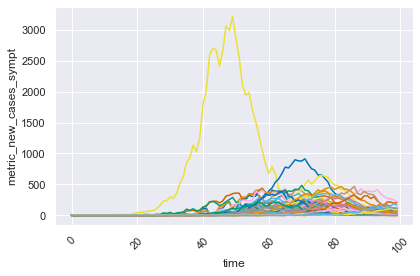

In [29]:
#sns.scatterplot(
sns.lineplot(
             x="time", 
             #y="metric_new_deaths",
             #y="metric_new_hospitalized",
             y="metric_new_cases_sympt", 
             palette="colorblind", hue="myId",
             data=r_data,
            legend=False
            )#.legend(bbox_to_anchor= (1.03, 1) )

#ax.set_title('New Deaths', fontsize=20)
#ax.set_ylabel('Number of deaths')
#ax.legend(fontsize=10, title_fontsize=30, loc='upper left')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()

== POPULATION ==

In [ ]:
pop_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/preprocessed/census/census_sample_5perc_040521.csv"
p_data = pd.read_csv(pop_filename)



In [ ]:
p_data

In [ ]:
len(np.unique(p_data["household_id"])) # unique households?

In [ ]:
x = p_data.groupby(["age"]).count()
#df.groupby(['col1','col2']).agg({'col3':'sum','col4':'sum'})

In [ ]:
x["age"] = x.index

In [ ]:
sns.lineplot(x="age", 
             y="person_id", data=x)

In [ ]:
a = p_data.hist("age")
